# Dog Breed classification

Notre projet est un projet pour une association de protection des animaux, qui ont une base de données énorme avec les images de tous les chiens, ce qui devient difficile pour eux de classifier ces données, pour cela on a décidé de créer un algorithme qui est capable de classifier les images en fonction de la race du chien présent sur l’image.

In [1]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [3]:
import keras

In [4]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import os

In [5]:
os.getcwd()
os.chdir(r'C:\Users\Utilisateur\Desktop\projet dog')
os.getcwd()

'C:\\Users\\Utilisateur\\Desktop\\projet dog'

Avant d'aller plus loin dans la création de CNN, commençons par jeter un coup d'œil à l'ensemble de données fourni dont la distribution est la suivante.

In [6]:
# fonction qui permet de charger train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

In [7]:
# load train, test, and validation datasets
train_files, train_targets = load_dataset(r'C:\Users\Utilisateur\Desktop\projet dog\test')
test_files, test_targets = load_dataset(r'C:\Users\Utilisateur\Desktop\projet dog\train')
valid_files, valid_targets = load_dataset(r'C:\Users\Utilisateur\Desktop\projet dog\valid')

In [8]:
# Charger la liste des chiens
dog_names = [item[20:-1] for item in sorted(glob(r'C:\Users\Utilisateur\Desktop\projet dog\test\*'))]


In [9]:
# Afficher les stats sur nos données
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 120 total dog categories.
There are 61740 total dog images.

There are 20580 training dog images.
There are 20580 validation dog images.
There are 20580 test dog images.


In [10]:

import cv2
from PIL import ImageFile
import matplotlib.pyplot as plt                        
%matplotlib inline
import pandas as pd

# DATA EXPLORATION

In [11]:

# Pour explorer les images, j'ai créé une fonction qui affiche une image a partir d'un index
def display_image(x):
   
    img = cv2.imread(train_files[x])
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()

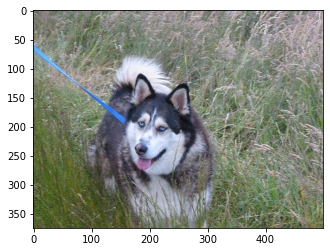

In [45]:

display_image(674)

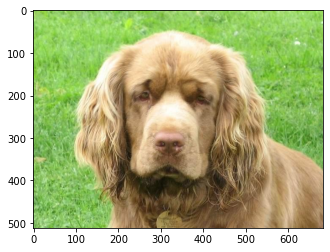

In [13]:
display_image(248)

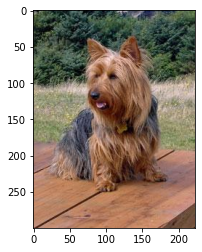

In [14]:
display_image(550)

In [15]:
#J'ai également créé une base de données à partir de l'ensemble de formation pour vérifier 
#la distribution des images par race.

def create_train_dog_breeds():
    '''
    fonction créer une trame de données à partir du training set
    '''
    list_names = []
    num_files = []
    dog_db = pd.DataFrame()

    for  folder in sorted(glob(r'C:\Users\Utilisateur\Desktop\projet dog\test\*')):
        list_names.append(folder[20:-1])
        num_files.append(len(folder))    
    dog_db['dog_breed'] = list_names
    dog_db['qty_image'] = num_files
    return dog_db

In [16]:
df_train_dog_breeds = create_train_dog_breeds()


In [46]:
#Afficher les 5 premieres races de chiens
df_train_dog_breeds.head(5)


,dog_breed,qty_image
0,\Desktop\projet dog\test\n02085620-Chihuahu,64
1,\Desktop\projet dog\test\n02085782-Japanese_sp...,71
2,\Desktop\projet dog\test\n02085936-Maltese_do,66
3,\Desktop\projet dog\test\n02086079-Pekines,63
4,\Desktop\projet dog\test\n02086240-Shih-Tz,63


In [18]:
#Stats pour décrire notre dataset
df_train_dog_breeds.describe()


,qty_image
count,120.000000
mean,68.258333
std,5.789727
min,58.000000
25%,63.000000
50%,68.000000
75%,72.000000
max,85.000000


In [19]:
#Afficher toutes les races
df_train_dog_breeds


,dog_breed,qty_image
0,\Desktop\projet dog\test\n02085620-Chihuahu,64
1,\Desktop\projet dog\test\n02085782-Japanese_sp...,71
2,\Desktop\projet dog\test\n02085936-Maltese_do,66
3,\Desktop\projet dog\test\n02086079-Pekines,63
4,\Desktop\projet dog\test\n02086240-Shih-Tz,63
...,...,...
115,\Desktop\projet dog\test\n02113799-standard_poodl,70
116,\Desktop\projet dog\test\n02113978-Mexican_hai...,71
117,\Desktop\projet dog\test\n02115641-ding,60
118,\Desktop\projet dog\test\n02115913-dhol,60


In [20]:
#Afficher un plot bar avec les differentes races qu'on a sur notre base, ainsi que le nombre d'image pour chaque race
def plot_bar_df(x,x_label,y, y_label,title):
  
    
    plt.figure(figsize=(15,4))
    plt.xticks(rotation=90)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.bar(x,y)
    plt.show()

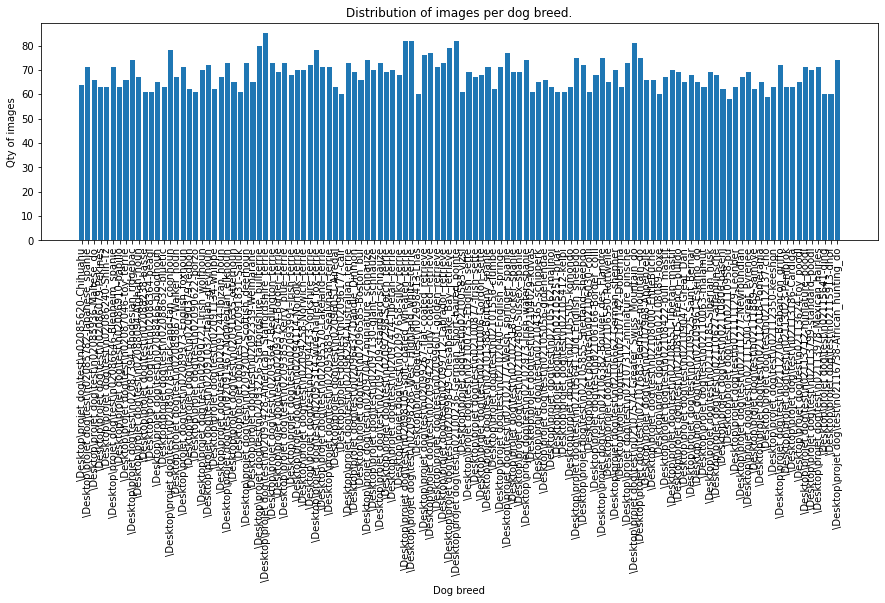

In [21]:
#Comme nous pouvons le voir dans l'image ci-dessus, l'ensemble de données est assez bien réparti parmi les 133 races
plot_bar_df(df_train_dog_breeds['dog_breed'], 'Dog breed', df_train_dog_breeds['qty_image'], 'Qty of images', 
            'Distribution of images per dog breed.' )

# Step 2: Detect Dogs

Dans cette section, nous utilisons un modèle ResNet-50 pré-formé pour détecter les chiens dans les images.
La première ligne télécharge le modèle ResNet-50, ainsi que les poids qui ont été formés sur ImageNet, un très grand ensemble de données très populaire utilisé pour la classification d'images et d'autres tâches de vision. 

In [22]:

from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

#Pre-processing
Lors de l'utilisation de TensorFlow comme backend, les CNN Keras nécessitent un tableau 4D en entrée, avec une forme où nb_samples correspond au nombre total d'images , et de lignes, colonnes et les canaux correspondent respectivement au nombre de lignes, de colonnes et de canaux pour chaque image.

In [23]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

La fonction path_to_tensor ci-dessous prend un chemin de fichier de valeur chaîne vers une image couleur en entrée et renvoie un tenseur 4D adapté à la fourniture à un CNN Keras. La fonction charge d'abord l'image et la redimensionne en une image carrée de 224 $ \ fois 224 $ pixels. Ensuite, l'image est convertie en un tableau, qui est ensuite redimensionné en un tenseur 4D. Dans ce cas, puisque nous travaillons avec des images couleur, chaque image a trois canaux. De même, puisque nous traitons une seule image (ou échantillon), le tenseur retourné aura toujours la forme

In [24]:

from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

In [25]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151))

# Create a CNN to Classify Dog Breeds (from Scratch)

Maintenant que nous avons des fonctions pour détecter les chiens dans les images, nous avons besoin d'un moyen de prédire la race à partir d'images. Dans cette étape, vous allez créer un CNN qui classe les races de chiens.

In [26]:
#Nous redimensionnons les images en divisant chaque pixel de chaque image par 255.
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|███████████████████████████████████████████████████████████████████████████| 20580/20580 [01:36<00:00, 212.77it/s]


In [27]:
train_tensors.shape


(20580, 224, 224, 3)

In [28]:
test_tensors.shape


(20580, 224, 224, 3)

In [29]:
valid_tensors.shape


(20580, 224, 224, 3)

In [31]:
num_classes = 133


J'ai utilisé l'architecture suggérée et ajouté quelques fonctionnalités. J'ai ajouté trois couches de convolution 2D, trois couches Max Pooling, une couche Global Average Pooling, des couches denses et une couche Dropout. J'ai utilisé Max Pooling, qui réduit le nombre de paramètres dans le modèle, le Global Average Pooling et la couche Dropout qui minimisent le surajustement en réduisant le nombre total de paramètres dans le modèle et en ignorant certains neurones pendant la phase d'entraînement.

In [32]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.

model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.15))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(num_classes, activation='softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0

In [33]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:

from keras.callbacks import ModelCheckpoint  

epochs = 5


In [37]:

### içi sur la fasse d'entrainement du model, puisqu'il prend beaucoup de temps pour la campliation.
#J'ai baissé le nombre d'epochs jusqu'a 5 epochs seulement, je sais que je vais avoir moins de précision

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=25, callbacks=[checkpointer], verbose=1)

Epoch 1/5
824/824 [==============================] - 508s 616ms/step - loss: 4.7738 - accuracy: 0.0143 - val_loss: 4.7059 - val_accuracy: 0.0172

Epoch 00001: val_loss improved from inf to 4.70587, saving model to saved_models\weights.best.from_scratch.hdf5
Epoch 2/5
824/824 [==============================] - 508s 617ms/step - loss: 4.6771 - accuracy: 0.0218 - val_loss: 4.6460 - val_accuracy: 0.0242

Epoch 00002: val_loss improved from 4.70587 to 4.64595, saving model to saved_models\weights.best.from_scratch.hdf5
Epoch 3/5
824/824 [==============================] - 512s 622ms/step - loss: 4.5893 - accuracy: 0.0279 - val_loss: 4.5256 - val_accuracy: 0.0354

Epoch 00003: val_loss improved from 4.64595 to 4.52563, saving model to saved_models\weights.best.from_scratch.hdf5
Epoch 4/5
824/824 [==============================] - 525s 638ms/step - loss: 4.5181 - accuracy: 0.0339 - val_loss: 4.5058 - val_accuracy: 0.0298

Epoch 00004: val_loss improved from 4.52563 to 4.50577, saving model to 

In [38]:

model.load_weights('saved_models/weights.best.from_scratch.hdf5')

In [39]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 3.9213%


Comme on pouvait s'y attendre, notre modèle n'a pas vraiment fonctionné, mais il y a quelques raisons à cela. Tout d'abord, nous devons comprendre que notre CNN doit d'abord comprendre une image, des angles, des tailles et des parties des chiens. C'est pourquoi notre modèle n'a pas bien fonctionné, nous devrons probablement améliorer notre jeu de données et ajouter beaucoup plus de couches. Mais au fur et à mesure que vous ajoutez des couches plus complexes, le temps de formation augmentera.